Had to import a train data instead of a prior data because of a significant shortage of memories (have got only 8GB RAM!)

## Import Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

## Import CSV Files from a local drive

In [2]:
order_products_train = pd.read_csv("order_products__train.csv")
orders = pd.read_csv("orders.csv")
products = pd.read_csv("products.csv")
aisles = pd.read_csv("aisles.csv")
departments = pd.read_csv("departments.csv")
sample_submission = pd.read_csv("sample_submission.csv")

#### Order_Products_Train Sheet (주문순서코드 및 상품코드, 주문별 장바구니 담은 순서 및 재구매여부)

In [5]:
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [50]:
len(order_products_train)

1384617

#### Orders Sheet (주문번호, 고객번호, 자료유형, 주문차수번호, 주문요일, 주문시간, 마지막 주문 후 지난 날짜)

In [6]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


#### Products Sheet (상품코드, 상품명 및 분류코드)

In [7]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


#### Aisle and Departments Sheet (분류코드 및 분류명)

In [14]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [28]:
departments

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol
5,6,international
6,7,beverages
7,8,pets
8,9,dry goods pasta
9,10,bulk


#### Preview how to submit

In [51]:
sample_submission.tail(20)

,order_id,products
74980,3419878,39276 29259
74981,3419910,39276 29259
74982,3419934,39276 29259
74983,3420147,39276 29259
74984,3420168,39276 29259
74985,3420237,39276 29259
74986,3420327,39276 29259
74987,3420360,39276 29259
74988,3420390,39276 29259
74989,3420443,39276 29259


관건은 매 주문마다 그 다음 구매상품은 무엇이 될 것인가? 가 되겠다. 

### Join Tables

#### step 1. merge departments with value_count

In [3]:
# MERGE 1차 - 주문량에 따른 department

tmp_value_count = pd.DataFrame(products['department_id'].value_counts())
value_count_index = tmp_value_count.reset_index()

depart_c = pd.merge(left = departments, right = value_count_index, left_on = 'department_id', right_on='index')

del depart_c['index']

depart_c.columns = ['department_id', 'department', 'value_count']

In [4]:
depart_c

,department_id,department,value_count
0,1,frozen,4007
1,2,other,548
2,3,bakery,1516
3,4,produce,1684
4,5,alcohol,1054
5,6,international,1139
6,7,beverages,4365
7,8,pets,972
8,9,dry goods pasta,1858
9,10,bulk,38


각 Departments마다 얼마나 많은 상품들이 존재하는지 알 수 있다.

#### step 2. merge products with department & aisle (product name이 어느 department 및 aisle에 속하는지 직관적으로 보고파)

In [5]:
# MERGE 2차 - product name에 따른 department 유형

product_depart = pd.merge(left=products, right=departments, left_on='department_id', right_on='department_id')

In [6]:
product_depart.head()

,product_id,product_name,aisle_id,department_id,department
0,1,Chocolate Sandwich Cookies,61,19,snacks
1,16,Mint Chocolate Flavored Syrup,103,19,snacks
2,25,Salted Caramel Lean Protein & Fiber Bar,3,19,snacks
3,32,Nacho Cheese White Bean Chips,107,19,snacks
4,41,Organic Sourdough Einkorn Crackers Rosemary,78,19,snacks


In [55]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [59]:
product_dep_ai = pd.merge(left=product_depart, right=aisles, left_on='aisle_id', right_on='aisle_id')

In [61]:
product_dep_ai.head()

,product_id,product_name,aisle_id,department_id,department,aisle
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes
1,78,Nutter Butter Cookie Bites Go-Pak,61,19,snacks,cookies cakes
2,102,Danish Butter Cookies,61,19,snacks,cookies cakes
3,172,Gluten Free All Natural Chocolate Chip Cookies,61,19,snacks,cookies cakes
4,285,Mini Nilla Wafers Munch Pack,61,19,snacks,cookies cakes


상품들이 각각 어떤 Department에 속해 있는지 알 수 있다.

#### step 3. merge order_products_train with product_depart (reorder가 있는 product name과 deparment를 보고파)

In [62]:
# MERGE 3차 - reorder가 있는 product name, department 

reorder_product = pd.merge(left=order_products_train, right=product_dep_ai, left_on='product_id', right_on='product_id').sort_values(by='order_id')


In [63]:
reorder_product.head(10)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle
0,1,49302,1,1,Bulgarian Yogurt,120,16,dairy eggs,yogurt
3627,1,43633,5,1,Lightly Smoked Sardines in Olive Oil,95,15,canned goods,canned meat seafood
3651,1,13176,6,0,Bag of Organic Bananas,24,4,produce,fresh fruits
19131,1,47209,7,0,Organic Hass Avocado,24,4,produce,fresh fruits
26424,1,22035,8,1,Organic Whole String Cheese,21,16,dairy eggs,packaged cheese
1214,1,49683,4,0,Cucumber Kirby,83,4,produce,fresh vegetables
8,1,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,dairy eggs,other creams cheeses
152,1,10246,3,0,Organic Celery Hearts,83,4,produce,fresh vegetables
36714,36,46979,8,1,Asparagus,83,4,produce,fresh vegetables
28417,36,39612,1,0,Grated Pecorino Romano Cheese,2,16,dairy eggs,specialty cheeses


주문번호별 상품의 리오더 여부 및 분류(dep & asl)을 파악할 수 있다.

#### step 4. merge reorder_product with orders (user_id에 따른 구매이력 전반 조회)

In [64]:
# MERGE 4차 - user_id 에 따른 구매 이력

user_order_data = pd.merge(left=reorder_product, right=orders, left_on='order_id', right_on='order_id').sort_values(['user_id', 'order_number'], ascending=[True, True])

In [65]:
user_order_data.head(20)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
484420,1187899,39657,5,1,Milk Chocolate Almonds,45,19,snacks,candy chocolate,1,train,11,4,8,14.0
484421,1187899,10258,6,1,Pistachios,117,19,snacks,nuts seeds dried fruit,1,train,11,4,8,14.0
484422,1187899,25133,2,1,Organic String Cheese,21,16,dairy eggs,packaged cheese,1,train,11,4,8,14.0
484423,1187899,49235,10,1,Organic Half & Half,53,16,dairy eggs,cream,1,train,11,4,8,14.0
484424,1187899,196,1,1,Soda,77,7,beverages,soft drinks,1,train,11,4,8,14.0
484425,1187899,26088,8,1,Aged White Cheddar Popcorn,23,19,snacks,popcorn jerky,1,train,11,4,8,14.0
484426,1187899,38928,3,1,0% Greek Strained Yogurt,120,16,dairy eggs,yogurt,1,train,11,4,8,14.0
484427,1187899,27845,9,0,Organic Whole Milk,84,16,dairy eggs,milk,1,train,11,4,8,14.0
484428,1187899,46149,11,1,Zero Calorie Cola,77,7,beverages,soft drinks,1,train,11,4,8,14.0
484429,1187899,13032,7,1,Cinnamon Toast Crunch,121,14,breakfast,cereal,1,train,11,4,8,14.0


In [66]:
user_order_data.tail()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
111267,272231,15655,5,0,Dark Chocolate Mint Snacking Chocolate,45,19,snacks,candy chocolate,206209,train,14,6,14,30.0
111268,272231,39216,8,1,Original Multigrain Spoonfuls Cereal,121,14,breakfast,cereal,206209,train,14,6,14,30.0
111269,272231,37966,7,0,French Baguette Bread,112,3,bakery,bread,206209,train,14,6,14,30.0
111270,272231,9405,2,1,Calcium Enriched 100% Lactose Free Fat Free Milk,91,16,dairy eggs,soy lactosefree,206209,train,14,6,14,30.0
111271,272231,24852,3,1,Banana,24,4,produce,fresh fruits,206209,train,14,6,14,30.0


최종 Table!

## Time to do EDA for remarkable INSIGHTS!

#### Number of Products that Customers usually Order

In [70]:
order_products_all = pd.concat([order_products_train, order_products_prior], axis=0)

print("The order_products_all size is : ", order_products_all.shape)

The order_products_all size is :  (33819106, 4)


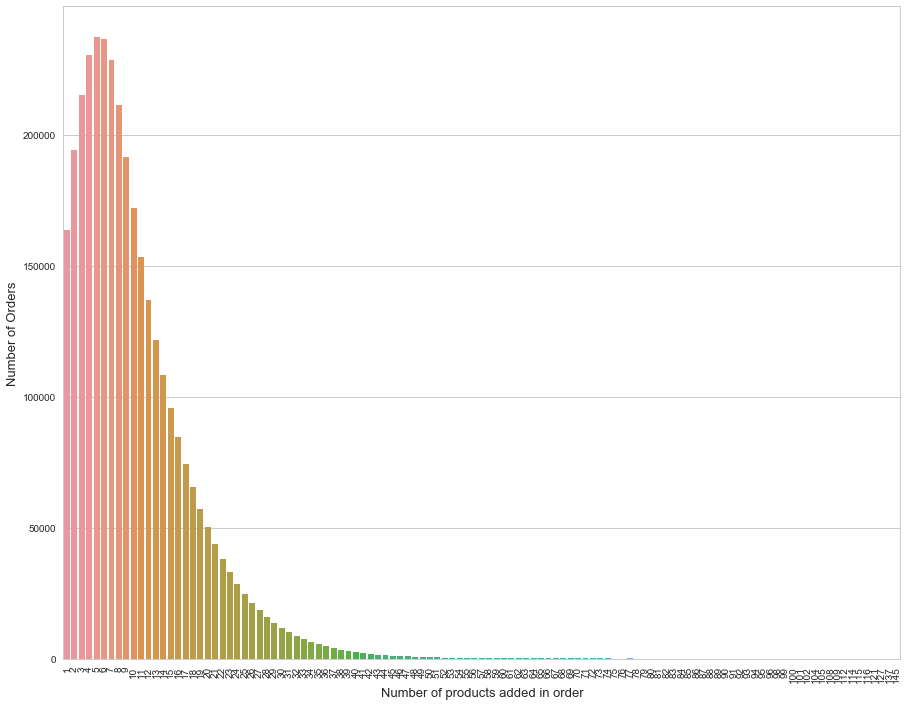

In [71]:
grouped = order_products_all.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
grouped = grouped.add_to_cart_order.value_counts()

sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)

plt.ylabel('Number of Orders', fontsize=13)
plt.xlabel('Number of products added in order', fontsize=13)
plt.show()

대부분 한 번에 3~7 개의 상품을 주문하는 경향이 있었으며, 드물게 대량의 상품을 구매하는 경우도 존재하였다.

#### Most Ordered Products

In [72]:
grouped = order_products_all.groupby("product_id")["reordered"].aggregate({'Total_reorders': 'count'}).reset_index()
grouped = pd.merge(grouped, products[['product_id', 'product_name']], how='left', on=['product_id'])
grouped = grouped.sort_values(by='Total_reorders', ascending=False)[:10]
grouped

C:\Python3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


,product_id,Total_reorders,product_name
24849,24852,491291,Banana
13173,13176,394930,Bag of Organic Bananas
21134,21137,275577,Organic Strawberries
21900,21903,251705,Organic Baby Spinach
47205,47209,220877,Organic Hass Avocado
47762,47766,184224,Organic Avocado
47622,47626,160792,Large Lemon
16794,16797,149445,Strawberries
26206,26209,146660,Limes
27842,27845,142813,Organic Whole Milk


바나나, 딸기, 시금치, 아보카도, 레몬, ... 과일 및 채소류가 압도적으로 구매 빈도가 높았다.

#### Reorder Frequency

In [86]:
grouped2 = order_products_all.groupby("reordered")["product_id"].aggregate({'Total_products': 'count'}).reset_index()
grouped2['Ratios'] = grouped2["Total_products"].apply(lambda x: x /grouped2['Total_products'].sum())
grouped2.round(3)

C:\Python3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


,reordered,Total_products,Ratios
0,0,13863746,0.41
1,1,19955360,0.59


재구매 비율은 59%

In [94]:
grouped3  = grouped2.groupby(['reordered']).sum()['Total_products'].sort_values(ascending=False)

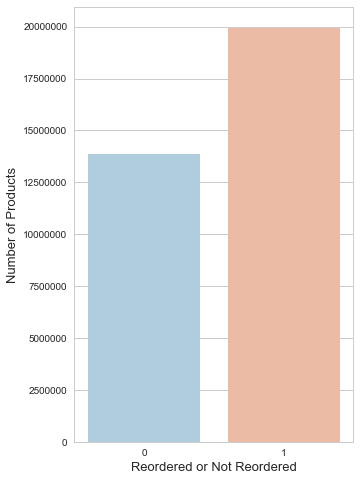

In [99]:
sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(5, 8))
sns.barplot(grouped3.index, grouped3.values, palette='RdBu_r')
plt.ylabel('Number of Products', fontsize=13)
plt.xlabel('Reordered or Not Reordered', fontsize=13)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

모든 구매 발생 건수를 나열했을 때, 2,000만건 정도 재구매

#### Most Reordered Products

In [101]:
grouped4 = order_products_all.groupby("product_id")["reordered"].aggregate({'reorder_sum': sum,'reorder_total': 'count'}).reset_index()
grouped4['reorder_probability'] = grouped4['reorder_sum'] / grouped4['reorder_total']
grouped4 = pd.merge(grouped4, products[['product_id', 'product_name']], how='left', on=['product_id'])
grouped4 = grouped4[grouped4.reorder_total > 75].sort_values(['reorder_probability'], ascending=False)[:10]
grouped4

C:\Python3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


,product_id,reorder_sum,reorder_total,reorder_probability,product_name
2074,2075,84,90,0.933333,Serenity Ultimate Extrema Overnight Pads
27737,27740,94,102,0.921569,Chocolate Love Bar
35601,35604,93,104,0.894231,Maca Buttercups
38248,38251,99,111,0.891892,Benchbreak Chardonnay
36798,36801,88,99,0.888889,Organic Blueberry B Mega
10233,10236,114,131,0.870229,Fragrance Free Clay with Natural Odor Eliminat...
20595,20598,99,114,0.868421,Thousand Island Salad Snax
5455,5457,78,90,0.866667,Classic Carbonated Natural Mineral Water
35493,35496,394,457,0.862144,Real2 Alkalized Water 500 ml
9289,9292,2580,2995,0.861436,Half And Half Ultra Pasteurized


In [13]:
user_order_data.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
484420,1187899,39657,5,1,Milk Chocolate Almonds,45,19,snacks,1,train,11,4,8,14.0
484421,1187899,10258,6,1,Pistachios,117,19,snacks,1,train,11,4,8,14.0
484422,1187899,25133,2,1,Organic String Cheese,21,16,dairy eggs,1,train,11,4,8,14.0
484423,1187899,49235,10,1,Organic Half & Half,53,16,dairy eggs,1,train,11,4,8,14.0
484424,1187899,196,1,1,Soda,77,7,beverages,1,train,11,4,8,14.0


#### Most Ordered Departments

In [22]:
grouped6 = user_order_data.groupby("department")["reordered"].aggregate({'reorder_sum': sum, 'reorder_total' : 'count'}).reset_index()

C:\Python3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


In [23]:
grouped6['reorder_probability'] = grouped6['reorder_sum'] / grouped6['reorder_total']

In [94]:
reo_top_dep = grouped6.sort_values(by='reorder_probability', ascending=False)[:10] # Reorder Top 10
reo_top_dep

,department,reorder_sum,reorder_total,reorder_probability
7,dairy eggs,146502,217051,0.674966
19,produce,271886,409087,0.664617
3,beverages,75060,114046,0.658155
2,bakery,30692,48394,0.634211
18,pets,2834,4497,0.630198
8,deli,27367,44291,0.617891
0,alcohol,3397,5598,0.606824
13,meat seafood,17907,30307,0.590854
20,snacks,69102,118862,0.581363
5,bulk,786,1359,0.578366


In [95]:
reo_bottom_dep = grouped6.sort_values(by='reorder_probability', ascending=True)[:10] # Reorder Bottom 10
reo_bottom_dep

,department,reorder_sum,reorder_total,reorder_probability
17,personal care,7271,21570,0.337089
16,pantry,29498,81242,0.363088
12,international,4522,11902,0.379936
14,missing,3148,8251,0.381530
15,other,697,1795,0.388301
11,household,15372,35986,0.427166
6,canned goods,22782,46799,0.486805
9,dry goods pasta,18885,38713,0.487821
1,babies,8084,14941,0.541062
10,frozen,56168,100426,0.559297


personal care, pantry, international, missing, household 등은 재구매율이 낮다.

Dep.별 재구매율 상위 10

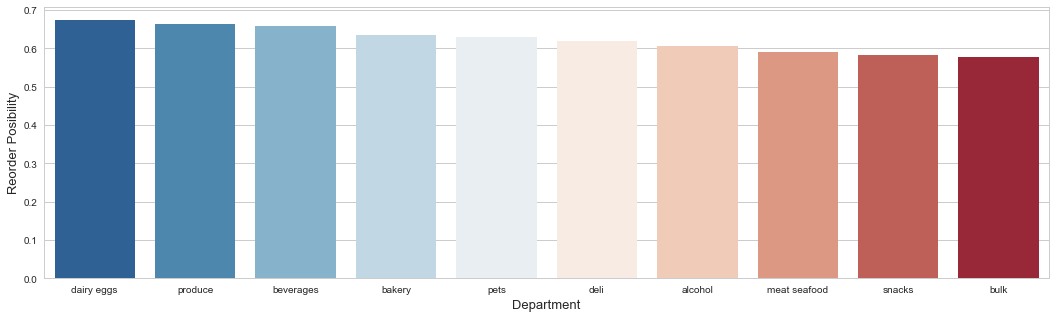

In [96]:
sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(18, 5))
sns.barplot(reo_top_dep['department'], reo_top_dep['reorder_probability'], palette='RdBu_r')
plt.ylabel('Reorder Posibility', fontsize=13)
plt.xlabel('Department', fontsize=13)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

- 달걀, 빵, 날생선 등의 유통기한이 짧은 식료품과 주류, 음료, 과자 등 습관적으로 마시는 음료가 상위 Dep.를 형성하고 있었다.

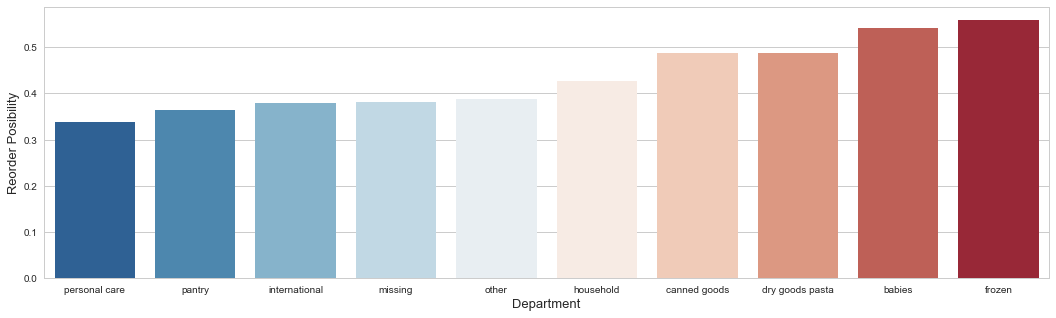

In [97]:
sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(18, 5))
sns.barplot(reo_bottom_dep['department'], reo_bottom_dep['reorder_probability'], palette='RdBu_r')
plt.ylabel('Reorder Posibility', fontsize=13)
plt.xlabel('Department', fontsize=13)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

- 개인 위생용품, 선반, 수입품, 통조림 등이 대표적인 재구매율 50% 이하의 상품들이다.

##### Insights

- Dep. 기준 재구매율에서도 상식적인 구매빈도가 높을만한 상품들이 재구매율이 높게 나타났으며 사용연한(감가상각)이 큰 제품들의 재구매 비율이 낮았다.

- 조금더 세분화된 기준인 Aisle을 기준으로 재구매 비율을 산출해보도록 해야겠다.

#### Most Ordered Aisles

In [67]:
user_order_data.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
484420,1187899,39657,5,1,Milk Chocolate Almonds,45,19,snacks,candy chocolate,1,train,11,4,8,14.0
484421,1187899,10258,6,1,Pistachios,117,19,snacks,nuts seeds dried fruit,1,train,11,4,8,14.0
484422,1187899,25133,2,1,Organic String Cheese,21,16,dairy eggs,packaged cheese,1,train,11,4,8,14.0
484423,1187899,49235,10,1,Organic Half & Half,53,16,dairy eggs,cream,1,train,11,4,8,14.0
484424,1187899,196,1,1,Soda,77,7,beverages,soft drinks,1,train,11,4,8,14.0


In [69]:
grouped7 = user_order_data.groupby("aisle")["reordered"].aggregate({'reorder_sum': sum, 'reorder_total' : 'count'}).reset_index()
grouped7['reorder_probability'] = grouped7['reorder_sum'] / grouped7['reorder_total']

C:\Python3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


In [75]:
grouped7.sort_values(by='reorder_probability', ascending=False)[:10] # Reorder Top 10

,aisle,reorder_sum,reorder_total,reorder_probability
83,milk,25864,32644,0.792305
131,water seltzer sparkling water,27011,36617,0.737663
50,fresh fruits,110782,150473,0.736225
41,eggs,14488,19875,0.728956
96,packaged produce,9657,13460,0.717459
33,cream,8510,12356,0.688734
119,soy lactosefree,18046,26240,0.687729
133,yogurt,37939,55240,0.686803
132,white wines,744,1088,0.683824
11,bread,16073,23635,0.680051


In [82]:
reo_top10 = grouped7.sort_values(by='reorder_probability', ascending=False)[:10]

In [76]:
grouped7.sort_values(by='reorder_probability', ascending=True)[:10] # Reorder Bottom 10

,aisle,reorder_sum,reorder_total,reorder_probability
122,spices seasonings,1534,9279,0.165320
7,baking supplies decor,192,1094,0.175503
76,kitchen supplies,82,448,0.183036
47,first aid,117,539,0.217069
29,cold flu allergy,294,1346,0.218425
8,beauty,66,287,0.229965
115,skin care,138,534,0.258427
86,more household,231,891,0.259259
48,food storage,766,2906,0.263593
67,hair care,392,1469,0.266848


In [84]:
reo_bottom10 = grouped7.sort_values(by='reorder_probability', ascending=True)[:10]

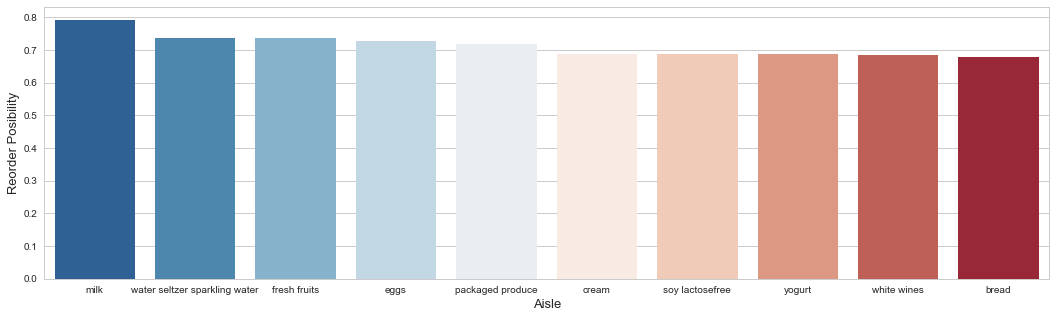

In [83]:
sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(18, 5))
sns.barplot(reo_top10['aisle'], reo_top10['reorder_probability'], palette='RdBu_r')
plt.ylabel('Reorder Posibility', fontsize=13)
plt.xlabel('Aisle', fontsize=13)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

Reorder 많은 상품 Top 10 : Milk, Water Seltzer Sparkling Water, Fresh Fruites, Eggs 순서

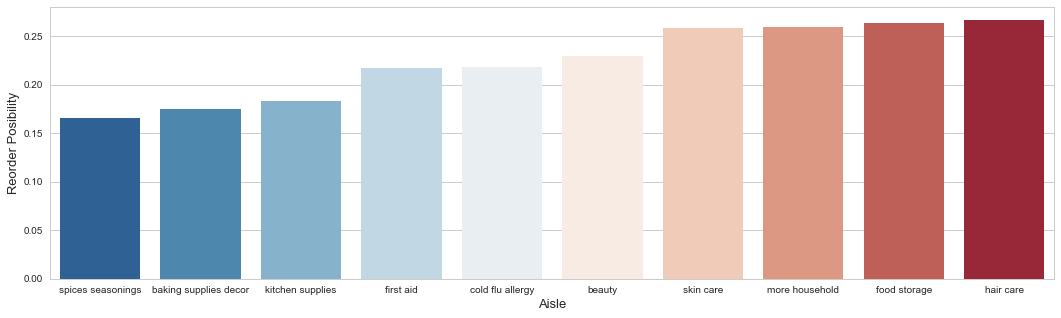

In [86]:
sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(18, 5))
sns.barplot(reo_bottom10['aisle'], reo_bottom10['reorder_probability'], palette='RdBu_r')
plt.ylabel('Reorder Posibility', fontsize=13)
plt.xlabel('Aisle', fontsize=13)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

Reorder 드문 상품 Top10 : Spices Seasonings, Baking Supplies Decor, Kitchen Supplies, Fresh Aid, Cold Flu Allegy, Beauty 순...

##### Insights

- 유통기한이 짧은 유제품, 야채, 과일 등의 식료품의 구매 빈도가 높으며,
- 유통기한이 최소 분기 이상인 생활용품, 의약품, 화장품등이 구매 빈도가 낮았다. 
- 전체적으로 Department 분류와 비슷한 상식적인 인사이트를 얻을 수 있었다.

#### Periods of Reorder

In [100]:
user_order_data.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
484420,1187899,39657,5,1,Milk Chocolate Almonds,45,19,snacks,candy chocolate,1,train,11,4,8,14.0
484421,1187899,10258,6,1,Pistachios,117,19,snacks,nuts seeds dried fruit,1,train,11,4,8,14.0
484422,1187899,25133,2,1,Organic String Cheese,21,16,dairy eggs,packaged cheese,1,train,11,4,8,14.0
484423,1187899,49235,10,1,Organic Half & Half,53,16,dairy eggs,cream,1,train,11,4,8,14.0
484424,1187899,196,1,1,Soda,77,7,beverages,soft drinks,1,train,11,4,8,14.0


In [103]:
user_order_data.max()

order_id                                                   3421070
product_id                                                   49688
add_to_cart_order                                               80
reordered                                                        1
product_name              with a Splash of Pineapple Coconut Water
aisle_id                                                       134
department_id                                                   21
department                                                  snacks
aisle                                                       yogurt
user_id                                                     206209
eval_set                                                     train
order_number                                                   100
order_dow                                                        6
order_hour_of_day                                               23
days_since_prior_order                                        

In [121]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [131]:
grouped8 = orders.groupby('order_id')["days_since_prior_order"].aggregate("sum").reset_index()
grouped8 = grouped8.days_since_prior_order.value_counts()

In [132]:
grouped8.head(20)

30.0    369323
7.0     320608
6.0     240013
4.0     221696
3.0     217005
5.0     214503
2.0     193206
8.0     181717
1.0     145247
9.0     118188
14.0    100230
10.0     95186
13.0     83214
11.0     80970
12.0     76146
0.0      67755
15.0     66579
16.0     46941
21.0     45470
17.0     39245
Name: days_since_prior_order, dtype: int64

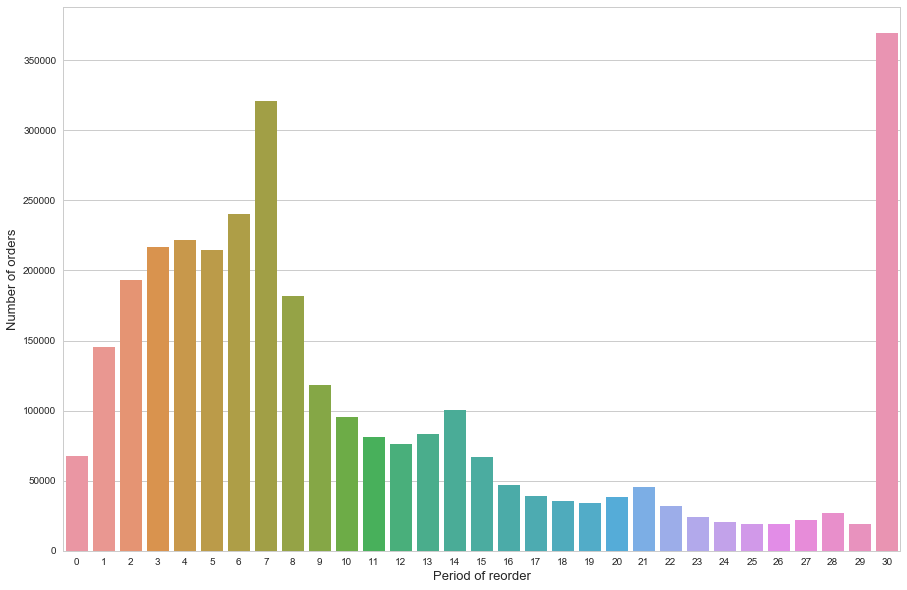

In [133]:
from matplotlib.ticker import FormatStrFormatter
f, ax = plt.subplots(figsize=(15, 10))
sns.barplot(grouped8.index, grouped8.values)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.ylabel('Number of orders', fontsize=13)
plt.xlabel('Period of reorder', fontsize=13)
plt.show()

##### Insights

- 7일 간격으로 재구매가 많이 일어나지만 아예 월별로 일어나는 구매 빈도가 오히려 더 높다!!